# Trabajando con `pipeline`

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Octubre de 2025  
**Versión:** 1.0

---

## Descripción

Este notebook contiene la explicación del uso de `pipeline` para construir un modelo predictivo para una variable continua considerando el tratamiento de valores atípicos en un set de datos.

En este caso, los valores atípicos se encuentran presentes en una de las variables independientes y en la variable objetivo.


[Acá más información](https://medium.com/@surajagrahari330/machine-learning-pipeline-from-raw-data-to-insightful-models-80c54914b7a9)

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.12. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```python
import pandas as pd
print(pd.__version__)
````

In [1]:
# Descargar el archivo y guardarlo en el entorno
!wget https://raw.githubusercontent.com/JaznaLaProfe/InteligenciaArtificial/master/data/taxi_data.csv

--2025-10-28 14:33:13--  https://raw.githubusercontent.com/JaznaLaProfe/InteligenciaArtificial/master/data/taxi_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67269 (66K) [text/plain]
Saving to: ‘taxi_data.csv’

taxi_data.csv       100%[===================>]  65.69K  --.-KB/s    in 0.008s  

2025-10-28 14:33:13 (8.55 MB/s) - ‘taxi_data.csv’ saved [67269/67269]



In [2]:
# Descargar el archivo y guardarlo en el entorno
!wget https://raw.githubusercontent.com/JaznaLaProfe/InteligenciaArtificial/master/data/descripcion_data_viajes.json

--2025-10-28 14:33:14--  https://raw.githubusercontent.com/JaznaLaProfe/InteligenciaArtificial/master/data/descripcion_data_viajes.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [text/plain]
Saving to: ‘descripcion_data_viajes.json’

descripcion_data_vi 100%[===================>]   1.01K  --.-KB/s    in 0.001s  

2025-10-28 14:33:14 (1.58 MB/s) - ‘descripcion_data_viajes.json’ saved [1038/1038]



![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*CKEc4j27kiRRJFJ-.jpg)

[Fuente de la imagen]( https://cdn.educba.com/academy/wp-content/uploads/2024/03/Machine-Learning-Pipeline.jpg)

[](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*CKEc4j27kiRRJFJ-.jpg)

In [26]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

In [6]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.05, 0.05)):
        self.limits = limits

    def fit(self, X, y=None):
        # Guardar nombres si es DataFrame, si no generar nombres genéricos
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
        else:
            self.columns_ = np.arange(X.shape[1])
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns_)
        for col in self.columns_:
            lower = X[col].quantile(self.limits[0])
            upper = X[col].quantile(1 - self.limits[1])
            X[col] = np.clip(X[col], lower, upper)
        return X.values

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns_)
        else:
            return np.array(input_features)

# Carga los datos

In [7]:
data = pd.read_csv('taxi_data.csv')
data.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [8]:
pd.set_option('display.max_colwidth', None)
descripcion = pd.read_json("descripcion_data_viajes.json")
descripcion

,nombre,descripcion
0,Trip_Distance_km,Distancia total recorrida durante el viaje (en kilómetros)
1,Time_of_Day,"Momento del día en que se realizó el viaje: Morning, Afternoon, Evening, Night."
2,Day_of_Week,Día de la semana del viaje: Weekday o Weekend.
3,Passenger_Count,Cantidad de pasajeros transportados.
4,Traffic_Conditions,"Nivel de tráfico durante el viaje: Low, Medium, High."
5,Base_Fare,Tarifa base cobrada por iniciar el viaje.
6,Per_Km_Rate,Costo cobrado por kilómetro recorrido.
7,Per_Minute_Rate,Costo cobrado por minuto de viaje.
8,Trip_Duration_Minutes,Duración total del viaje en minutos.
9,Trip_Price,Precio total cobrado por el viaje.


In [9]:
duplicados = data[data.duplicated(keep=False)]
duplicados

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [11]:
# Muestra una tabla con los % de nulos de cada columna
columnas_con_nulos = data.isna().sum()[data.isna().sum() > 0]
porcentaje_nulos = (columnas_con_nulos / data.shape[0]) * 100

resultado = pd.DataFrame({
    "Cantidad Nulos": columnas_con_nulos,
    "Porcentaje Nulos (%)": porcentaje_nulos
}).round(2)

resultado

,Cantidad Nulos,Porcentaje Nulos (%)
Trip_Distance_km,50,5.0
Time_of_Day,50,5.0
Day_of_Week,50,5.0
Passenger_Count,50,5.0
Traffic_Conditions,50,5.0
Weather,50,5.0
Base_Fare,50,5.0
Per_Km_Rate,50,5.0
Per_Minute_Rate,50,5.0
Trip_Duration_Minutes,50,5.0


In [12]:
data.describe(include=np.object_)

,Time_of_Day,Day_of_Week,Traffic_Conditions,Weather
count,950,950,950,950
unique,4,2,3,3
top,Afternoon,Weekday,Low,Clear
freq,371,655,397,667


In [13]:
for columna in data.describe(include=np.object_).columns:
  print(f"Valores únicos de {columna}")
  print(f"\t {data[columna].unique()}")

Valores únicos de Time_of_Day
	 ['Morning' 'Afternoon' 'Evening' 'Night' nan]
Valores únicos de Day_of_Week
	 ['Weekday' 'Weekend' nan]
Valores únicos de Traffic_Conditions
	 ['Low' 'High' 'Medium' nan]
Valores únicos de Weather
	 ['Clear' nan 'Rain' 'Snow']


In [15]:
def ver_negativos(data : pd.DataFrame, columna : str) -> bool:
  """
  Verifica si una columna contiene valores negativos.

  Parámetros
  ----------
  data : pd.DataFrame
    DataFrame que contiene la columna.
  columna : str
    Nombre de la columna.

  Retorna
  -------
  bool
    True si la columna contiene valores negativos, False en caso contrario.

  """
  return np.sum(data[columna] <= 0) > 0

In [16]:
for columna in data.describe().columns:
  print(f"{columna :>25} -> {'Inconsistente' if ver_negativos(data, columna) else 'Consistente'}")

         Trip_Distance_km -> Consistente
          Passenger_Count -> Consistente
                Base_Fare -> Consistente
              Per_Km_Rate -> Consistente
          Per_Minute_Rate -> Consistente
    Trip_Duration_Minutes -> Consistente
               Trip_Price -> Consistente


In [18]:
def buscar_atipicos(data : pd.DataFrame, columna : str) -> pd.DataFrame:
  """
  Busca valores atípicos en una columna.

  Parámetros
  ----------
  data : pd.DataFrame
    DataFrame que contiene la columna.
  columna : str
    Nombre de la columna.

  Retorna
  -------
  pd.DataFrame
    DataFrame con los valores atípicos.
  """
  # Calcular los límites
  Q1 = data[columna].quantile(0.25)
  Q3 = data[columna].quantile(0.75)
  # Calcula rango intercuartilico
  IQR = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR

  # Filtrar outliers
  return data[(data[columna] < limite_inferior) | (data[columna] > limite_superior)]

def obtener_cantidad_atipicos(data : pd.DataFrame, columnas : np.array) -> dict:
  """
  Obtiene la cantidad de atípicos por cada columna.

  Parámetros
  ----------
  data : pd.DataFrame
    DataFrame que contiene las columnas.
  columnas : np.array
    Nombres de las columnas.

  Retorna
  -------
  dict
    Diccionario con la cantidad de atípicos por cada columna.
  """
  total_atipicos = {}
  for columna in data[columnas]:
    atipicos = buscar_atipicos(data, columna)
    total_atipicos[columna] = atipicos.shape[0]
  return total_atipicos

In [19]:
atipicos_por_columna = obtener_cantidad_atipicos(data, data.describe().columns)
pd.DataFrame(atipicos_por_columna, index=["Cantidad"]).T

,Cantidad
Trip_Distance_km,20
Passenger_Count,0
Base_Fare,0
Per_Km_Rate,0
Per_Minute_Rate,0
Trip_Duration_Minutes,0
Trip_Price,26


In [20]:
columnas_con_atipicos = [columna for columna, num_atipicos in atipicos_por_columna.items() if num_atipicos > 0]

columnas_con_atipicos

['Trip_Distance_km', 'Trip_Price']

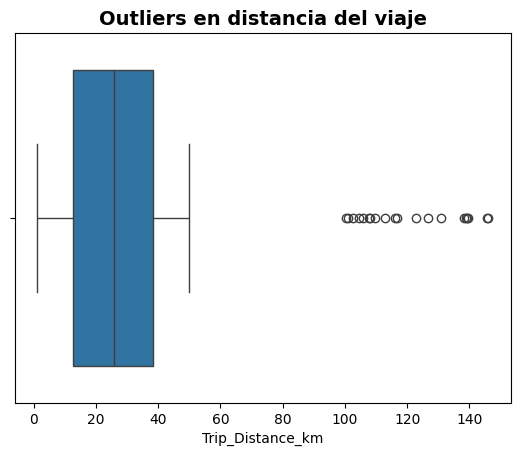

In [21]:
# Visualización de outliers en distancia de viaje
sb.boxplot(x=data["Trip_Distance_km"])
plt.title("Outliers en distancia del viaje", fontsize=14, fontweight="bold")
plt.show()

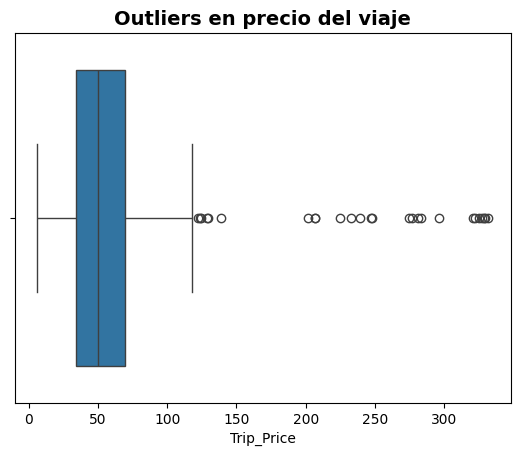

In [22]:
# Visualización de outliers en precio de viaje
sb.boxplot(x=data["Trip_Price"])
plt.title("Outliers en precio del viaje", fontsize=14, fontweight="bold")
plt.show()

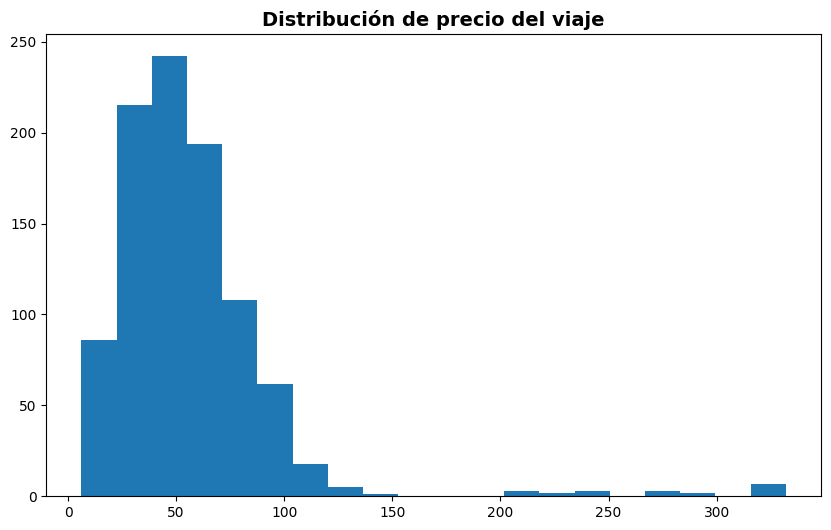

In [23]:
data.Trip_Price.hist(bins=20, figsize=(10,6), grid=False)
plt.title("Distribución de precio del viaje", fontsize=14, fontweight="bold")
plt.show()

In [24]:
# Define las características "features" que formaran parte del modelo
features_num = np.array(data.describe().columns)
features_cat = np.array(data.describe(include=np.object_).columns)

In [25]:
# Muestra las variables independientes que forman parte del modelo
print(f"Features numéricas: {features_num}")
print(f"Features categóricas: {features_cat}")

Features numéricas: ['Trip_Distance_km' 'Passenger_Count' 'Base_Fare' 'Per_Km_Rate'
 'Per_Minute_Rate' 'Trip_Duration_Minutes' 'Trip_Price']
Features categóricas: ['Time_of_Day' 'Day_of_Week' 'Traffic_Conditions' 'Weather']


In [63]:
# Preprocesamiento numérico: Tratamiento de atípicos + imputación con mediana + escalado
numeric_transformer = Pipeline(steps=[
    ("winsorizer", Winsorizer(limits=(0.05, 0.05))),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Preprocesamiento categórico: imputación + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Combina en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_num),
        ("cat", categorical_transformer, features_cat)
    ]
)

In [64]:
# Define el target (variable objetivo)
target = "Trip_Price"

In [65]:
# Unifica las variables independientes
X = pd.concat([data[np.array(features_num)],
               data[np.array(features_cat)]], axis= 1)
# Variable dependiente
y = data[target]

In [49]:
def preparar_target(y : pd.Series, limits=(0.05, 0.05)) -> np.array:
  """
  Prepara la variable objetivo considerando limpieza de valores nulos y atípicos.

  Parámetros:
  -----------
    y : valores a ser tratados
    limits : tupla con los límites entregados a Windorizer

  Retorna:
  --------
    y_clean : valores limpios

  """

  y_clean = y.fillna(y.median())
  winsorizer_y = Winsorizer(limits=limits)
  return winsorizer_y.fit_transform(y_clean.to_frame()).ravel()


In [66]:
y_ready = preparar_target(y)

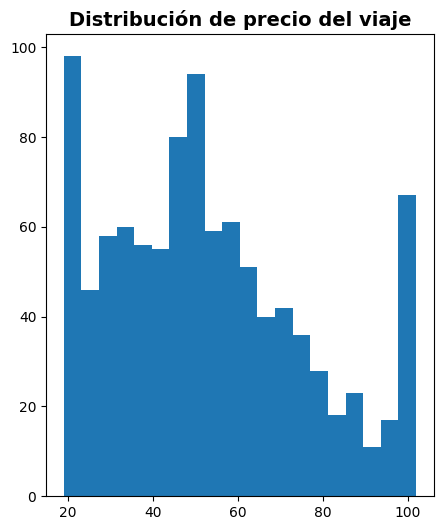

In [59]:
pd.DataFrame(y_ready).hist(bins=20, figsize=(5,6), grid=False)
plt.title("Distribución de precio del viaje", fontsize=14, fontweight="bold")
plt.show()

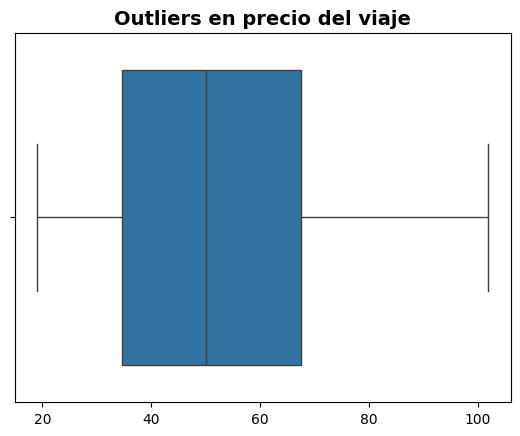

In [52]:
# Visualización de outliers en precio de viaje
sb.boxplot(x=y_ready)
plt.title("Outliers en precio del viaje", fontsize=14, fontweight="bold")
plt.show()

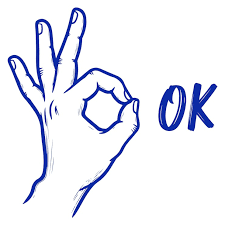

# Modelo de regresión

In [67]:
# Crea el pipeline final (preprocesamiento + modelo)
pipeline_modelo = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# División del conjunto de datos

In [68]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_ready, test_size=0.2, random_state=29)

# Entrenamiento
pipeline_modelo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  array(['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price'],
      dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather'],
      dtype=object))])),
                ('regressor', LinearRegression())])

In [69]:
# Predicciones
y_pred = pipeline_modelo.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Métricas del modelo ---")
print(f"{'RMSE' :<15}: {rmse:,.0f} USD")
print(f"{'R²' :<15}: {r2:.5f}")

print(f"{'MAE':<15}: {mae:,.0f} USD")
print(f"{'MSLE': <15}: {msle:.3f}")


--- Métricas del modelo ---
RMSE           : 1 USD
R²             : 0.99928
MAE            : 0 USD
MSLE           : 0.000
